CNN MODEL TO CLASSIFY MRI IMAGES AS HAVING TUMOR OR NO TUMOR

In [2]:
# Import necessary libraries
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [10]:
#Addresses of training dataset and validation dataset
train_dir = r"C:\Users\LENOVO\OneDrive\Desktop\tumor classification cnn\archive (10)\train"
val_dir = r"C:\Users\LENOVO\OneDrive\Desktop\tumor classification cnn\archive (10)\valid" 
test_dir=r"C:\Users\LENOVO\OneDrive\Desktop\tumor classification cnn\archive (10)\test"

In [11]:
"""As our Dataset in not in a desirable format we need to sepearate the images in train,tes
and validation sets into images which have tumor or not .
This code is simply to organize the data.
"""
import os
import json
import shutil

# Define the base directory for the dataset
base_dir = r"C:\Users\LENOVO\OneDrive\Desktop\tumor classification cnn\archive (10)"

# Manually specify the exact paths to the annotation files
annotation_paths = {
    "train": r"C:\Users\LENOVO\OneDrive\Desktop\tumor classification cnn\archive (10)\train\_annotations.coco.json",  # Replace with the correct path
    "valid": r"C:\Users\LENOVO\OneDrive\Desktop\tumor classification cnn\archive (10)\valid\_annotations.coco.json",  # Replace with the correct path
    "test": r"C:\Users\LENOVO\OneDrive\Desktop\tumor classification cnn\archive (10)\test\_annotations.coco.json",  # Replace with the correct path
}

# Classes
classes = ["tumor", "no_tumor"] 

# Function to organize images based on COCO annotations
def organize_images_from_coco(dataset_name, annotation_file):
    dataset_dir = os.path.join(base_dir, dataset_name)
    image_dir = dataset_dir  # Images are in the same folder

    # Create class-based directories
    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

    # Read the COCO annotation file
    with open(annotation_file, "r") as f:
        data = json.load(f)

    # Map image IDs to their respective classes
    image_classes = {}
    for annotation in data["annotations"]:
        image_id = annotation["image_id"]
        category_id = annotation["category_id"]
        if category_id == 1:  # Tumor class
            image_classes[image_id] = "tumor"
        else:
            image_classes[image_id] = "no_tumor"

    # Move images to respective class folders
    for image_info in data["images"]:
        image_id = image_info["id"]
        filename = image_info["file_name"]
        class_name = image_classes.get(image_id, "no_tumor")  # Default to "no_tumor"
        src_path = os.path.join(image_dir, filename)
        dest_dir = os.path.join(dataset_dir, class_name)
        dest_path = os.path.join(dest_dir, filename)

        if os.path.exists(src_path):
            shutil.move(src_path, dest_path)
        else:
            print(f"Warning: {src_path} not found.")

# Organize images for each dataset
for dataset_name, annotation_file in annotation_paths.items():
    print(f"Organizing {dataset_name} dataset...")
    if not os.path.exists(annotation_file):
        print(f"Error: Annotation file not found at {annotation_file}")
        continue
    organize_images_from_coco(dataset_name, annotation_file)

print("Dataset organization complete.")



Organizing train dataset...
Organizing valid dataset...
Organizing test dataset...
Dataset organization complete.


In [12]:
# Step 2: Preprocess the data using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'  # Binary classification (tumor or no tumor)
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'  # Binary classification
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Maintain order for evaluation
)


Found 1502 images belonging to 2 classes.
Found 429 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Initialize the model
model = Sequential()

# Add an Input layer
model.add(Input(shape=(150, 150, 3)))

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps into a vector
model.add(Flatten())

# Fully connected (dense) layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to reduce overfitting
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Step 5: Train the model
history = model.fit(
    train_data,
    epochs=10,
    batch_size=32,
    validation_data=val_data
)

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 716ms/step - accuracy: 0.6981 - loss: 0.6331 - val_accuracy: 0.8671 - val_loss: 0.3095
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.8870 - loss: 0.3002 - val_accuracy: 0.9394 - val_loss: 0.1487
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - accuracy: 0.9758 - loss: 0.0932 - val_accuracy: 0.9697 - val_loss: 0.0824
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 399ms/step - accuracy: 0.9798 - loss: 0.0681 - val_accuracy: 0.9883 - val_loss: 0.0331
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.9852 - loss: 0.0630 - val_accuracy: 0.9930 - val_loss: 0.0290
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.9933 - loss: 0.0262 - val_accuracy: 0.9953 - val_loss: 0.0244
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 552ms/step - accuracy: 0.9834 - loss: 0.0471 - val_accuracy: 0.9883 - val_loss: 0.0345
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 554ms/step - accuracy: 0.9918 - loss: 0.0332 - val_accu

In [60]:
# Step 7: Save the trained model
model.save('tumor_detection_model.keras')
print("Model saved as tumor_detection_model.keras")

Model saved as tumor_detection_model.keras


Text(0.5, 1.0, 'Accuracy')

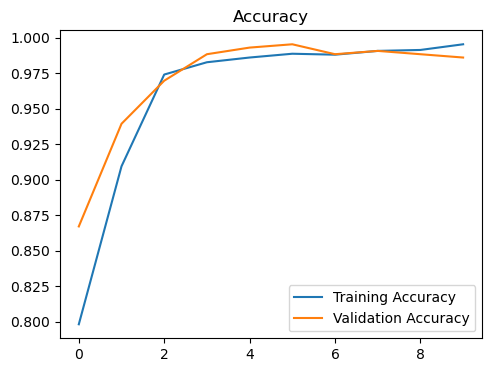

In [15]:
# Step 6: Plot training history (accuracy and loss)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

In [16]:
# Training and Validation accuracy after each epoch
print("Training Accuracy: ", history.history['accuracy'])
print("Validation Accuracy: ", history.history['val_accuracy'])

Training Accuracy:  [0.7982689738273621, 0.9094540476799011, 0.9740346074104309, 0.9826897382736206, 0.9860186576843262, 0.9886817336082458, 0.9880159497261047, 0.9906790852546692, 0.9913448691368103, 0.995339572429657]
Validation Accuracy:  [0.867132842540741, 0.939393937587738, 0.9696969985961914, 0.9883449673652649, 0.9930070042610168, 0.9953380227088928, 0.9883449673652649, 0.9906759858131409, 0.9883449673652649, 0.9860140085220337]


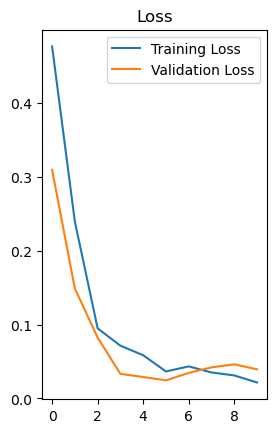

In [17]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [18]:
"""
# We need to predict the class labels for the validation dataset and compare with actual labels
# Step 9: Test with a single image (for example purposes)
"""
def predict_image(image_path, model):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    prediction = model.predict(img_array)
    return "Tumor Present" if prediction[0][0] > 0.5 else "No Tumor"

In [19]:
# Test the model with a new image
test_image_path = r"C:\Users\LENOVO\OneDrive\Desktop\tumor classification cnn\archive (10)\test\tumor\1864_jpg.rf.6708a8791c3ad5158aec5efed476784c.jpg"  # Update with the actual path of your test image
result = predict_image(test_image_path, model)
print(f"Prediction for test image: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Prediction for test image: Tumor Present


In [20]:
# Test the model with a new image
test_image_path = r"C:\Users\LENOVO\OneDrive\Desktop\tumor classification cnn\archive (10)\test\no_tumor\244_jpg.rf.65cbfcb7b085a1a1b55d83f611eb07f7.jpg"  # Update with the actual path of your test image
result = predict_image(test_image_path, model)
print(f"Prediction for test image: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Prediction for test image: No Tumor


In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Specify the test data directory (adjust path)
test_dir = r"C:\Users\LENOVO\OneDrive\Desktop\tumor classification cnn\archive (10)\test"  # Replace with your actual test directory path

# Load the test data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Adjust according to your input size
    batch_size=32,
    class_mode='binary'  # Assuming binary classification (tumor/no_tumor)
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, steps=len(test_data))

print("Test Accuracy: ", test_accuracy)


Found 215 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.9871 - loss: 0.0643
Test Accuracy:  0.9813953638076782


In [68]:
test_loss, test_accuracy = model.evaluate(test_data, steps=len(test_data))

print("Test Accuracy: ", test_accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.9821 - loss: 0.0841
Test Accuracy:  0.9813953638076782


In [69]:
from sklearn.metrics import classification_report
import numpy as np

# Get the true labels for the test dataset
y_true = val_data.classes  # For validation set (use test_data.classes for test set)

# Get the predicted labels
y_pred = model.predict(val_data)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary labels (0 or 1)

# Generate the classification report
report = classification_report(y_true, y_pred)
print(report)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       219
           1       0.49      0.49      0.49       210

    accuracy                           0.50       429
   macro avg       0.50      0.50      0.50       429
weighted avg       0.50      0.50      0.50       429



In [ ]:
from graphviz import Digraph

# Create a Digraph object
dot = Digraph(format='png')

# Define Nodes
dot.node('A', 'Start', shape='ellipse', style='filled', fillcolor='lightgray')
dot.node('B', 'Data Preprocessing\n(Augmentation, Normalization)', shape='parallelogram', style='filled', fillcolor='lightblue')
dot.node('C', 'Model Construction\n(CNN Layers, Optimizer, Loss)', shape='box', style='filled', fillcolor='lightgreen')
dot.node('D', 'Model Training\n(Train on Dataset)', shape='box', style='filled', fillcolor='lightyellow')
dot.node('E', 'Model Evaluation\n(Test Data, Metrics)', shape='box', style='filled', fillcolor='lightcoral')
dot.node('F', 'Prediction\n(Load MRI, Classify Tumor)', shape='box', style='filled', fillcolor='lightpink')
dot.node('G', 'End', shape='ellipse', style='filled', fillcolor='lightgray')

# Define Edges (Workflow Connections)
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')

# Render and display the diagram
dot.render('cnn_mri_workflow', view=True)
